In [1519]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import scipy.io
import collections


## for visualizing 
import matplotlib

In [1520]:
mat = scipy.io.loadmat('ML_banana_dataset.mat')

In [1521]:
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 22 18:55:49 2018',
 '__version__': '1.0',
 'data': array([[ 0.81189519, -0.19526175],
        [ 0.0949062 , -0.85442851],
        [-0.11382384, -0.14677222],
        ...,
        [-0.8892943 , -0.41712927],
        [ 0.85423303,  1.1491148 ],
        [-0.21093689, -0.49161562]]),
 'label': array([[ 1],
        [ 1],
        [ 1],
        ...,
        [ 1],
        [-1],
        [ 1]], dtype=int16)}

In [13]:
X_train = mat['data'][:500]
Y_train = mat['label'][:500]

In [15]:
print("Shape of the data : "+ str(X_train.shape))

Shape of the data : (500, 2)


In [28]:
ex = X_train[:4]
ex.shape

(4, 2)

In [166]:
def R(w,x): #simple auxiliary mapping
    
    opt = np.matmul(w.transpose(),x)
    cos = np.cos(opt)
   
    sin = np.sin(opt)
    
    return np.array([cos,sin])

In [528]:
def Z(D,X,w): # transform mxD vector to mx2D vector with R function
    for i in range (len(X)):
        z = R(w[0],X[i])
        for d in range (1,D):
            r = R(w[d],X[i])
            z = np.concatenate((z,r),axis=0)
        z = z.reshape(1,z.shape[0])
        z = z/np.sqrt(D)
        if i == 0:
            Z = z
        else:
            Z = np.concatenate((Z,z),axis=0)
        
    
    return Z

In [365]:
def Kernel(g,xi,xj):#Expected kernel
    dif = xi - xj
    r = (np.exp(-g*(np.linalg.norm(dif)**2))) 
    return r

In [546]:
def Err(X_train,X_train_2D,size,g): #Mean squared error between kernel and mapping
    err = 0
    for i in range (size):
        for j in range (size):
            zi = X_train_2D[i]
            zj = X_train_2D[j]
            sd = np.matmul(zi.transpose(),zj)
            ke = Kernel(g,X_train[i],X_train[j])
            dif = ke-sd
            err += np.linalg.norm(dif)**2
    return err/ np.square(size)
    
    
    

# To Create Weights
** Weights for that process should be taken from multivariate Gaussian density p(w) = N (w; μ, Σ) with zero mean μ = 0 and covariance Σ = 2gI (here, I is the identity matrix of the appropriate size).
By using sklearn library multivariate_normal densities based on mean and covariance matrices can be created.**

In [548]:
d=[1, 10, 20, 30, 40, 50]
g=2
feature_size = X_train.shape[1]
mean = np.zeros(feature_size)
cov = 2*g*np.identity(feature_size)

average_error=[]
for D in d:
    err = 0
    for T in range(10):
        w = np.random.multivariate_normal(mean,cov,(D))
        X_train_2D = Z(D,X_train,w)
        err += Err(X_train,X_train_2D,len(X_train),g)
    
    err = err/T
    average_error.append(err)

*According to Rahimi's paper, when D is increased expected error will decrease*

In [549]:
average_error

[0.49406696108150805,
 0.04866247443670573,
 0.025852027646003348,
 0.017042365018494647,
 0.012271093548255787,
 0.008971258603635306]

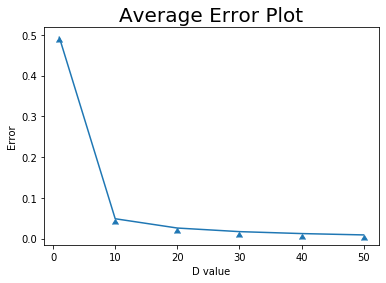

In [561]:
import matplotlib.pyplot as plt
x_axis = d
y_axis = average_error

plt.plot(x_axis, y_axis, marker=6)

plt.title('Average Error Plot', fontsize=20)
plt.xlabel('D value')
plt.ylabel('Error')


plt.show()

In [ ]:
########################################################################

**In this part, Firstly we will show that our data cannot be seperated with using linear classifier.
After that, we will create a single layer neural network.
We will make transformation in the first layer
Thus, Linear classification can be made in the last layer.
I will use softmax cross entropy loss function.**

In [916]:
def scatter_plot(X,Y):
    x = X[:,0]
    x = x.reshape(x.shape[0],1)
    y = X[:,1]
    y = y.reshape(y.shape[0],1)
    label = Y
    colors = ['red','green']

    fig = plt.figure(figsize=(8,8))
    plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))
    plt.title('Class Examples', fontsize=20)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    cb = plt.colorbar()
    loc = np.arange(0,max(label),max(label)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(colors)

In [1522]:
X_train = mat['data'][:5000]
Y_train = mat['label'][:5000]

In [1523]:
print("Shape of the data : "+ str(X_train.shape))

Shape of the data : (5000, 2)


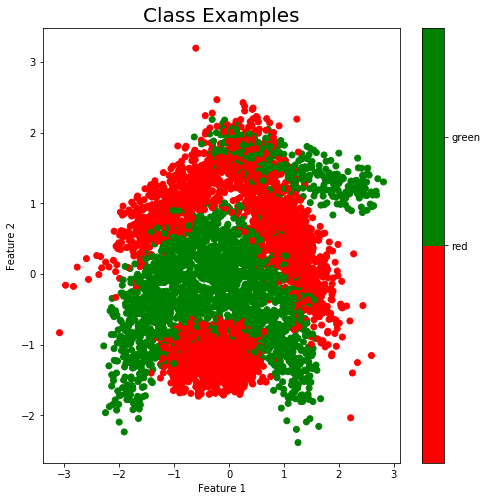

In [1524]:
scatter_plot(X_train,Y_train)

*On the figure above, we can see that green and red data points cannot be classified with using linear classifier!*

** Labels in this dataset are -1 and 1. I will convert them to 0 and 1**

In [1525]:
Y_train = Y_train.reshape(Y_train.shape[0]) # Reshape label vector to fit loss function.

In [1528]:
Y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=int16)

In [1527]:
for i in range(len(Y_train)): # Convert labels to 0 and 1 by adding +1 to -1
    if Y_train[i]==-1:
        Y_train[i]+=1

In [1531]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Neural Network
## For The First Layer
** We need to do randomized kernel transformation in the first layer.
As I mentioned above, weights for that process should be taken from multivariate Gaussian density p(w) = N (w; μ, Σ) with zero mean μ = 0 and covariance Σ = 2gI (here, I is the identity matrix of the appropriate size).
However, this process can be hard when we calculate derivatives for back-propagation.
Therefore, I create weight matrices and then clonned them to make easier our job.**

## Optimizer
** Vanilla, Momentum, RMSprob and Adam optimizers will be implemented.**


In [1601]:
class NeuralNet():
    
    def __init__(self,D=1,feature_size=2,g=2,layers=[2,2],iteration_counter=1,
                 minibach_size=32,
                 beta1=0.9,beta2=0.999,decay_rate=0.9,eps=1e-4,momentum=0.5,
                 learning_rate=0.001,reg=0.0001, epochs=100,train_flag=False,optimization="Vanilla"):
        self.params = {}
        self.layers = [D,layers[0],layers[1]]
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.D = D
        
        self.train_flag=train_flag
        self.optimization=optimization
        
        self.beta1=beta1
        self.beta2=beta2
        self.decay_rate=decay_rate
        self.momentum=momentum
        self.eps = eps
        
        self.iteration_counter=iteration_counter
        self.feature_size = feature_size
        self.g = g
        self.reg = reg
        self.loss = []
        self.sample_size = None
        self.X = None
        self.y = None
        self.minibach_size = minibach_size
        
    def double(self,w): # Make 2D our weight matrix
        a = np.zeros((2*w.shape[0],w.shape[1]))
        k=0
        for i in range(len(w)):
            a[k]=w[i]
            a[k+1]=w[i]
            k+=2
        return a
    
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        mean = np.zeros(self.feature_size)
        cov = 2*self.g*np.identity(self.feature_size)
        
        np.random.seed(1) # Seed the random number generator
        w = np.random.multivariate_normal(mean,cov,(self.D))
        
        
        self.params["W1"] = self.double(w).T
        self.params["v_W1"] = np.zeros(self.params["W1"].shape)
        self.params["m_W1"] = np.zeros(self.params["W1"].shape)
        
        self.params['W2'] = np.random.randn(2*self.D,self.layers[2])
        self.params["v_W2"] =np.zeros(self.params["W2"].shape)
        self.params["m_W2"] =np.zeros(self.params["W2"].shape)
        
        
        self.params['b2'] = np.zeros((1,self.layers[2]))
        self.params["v_b2"]=np.zeros(self.params["b2"].shape)
        self.params["m_b2"]=np.zeros(self.params["b2"].shape)

    def r_new(self,x):
        a = np.zeros((x.shape[0],x.shape[1]))
        for i in range(len(x)):
            k=0
            for j in range(int(x.shape[1]/2)):
                a[i][k] = np.cos(x[i][k])
                a[i][k+1] = np.sin(x[i][k+1])
                k+=2
        return a/np.sqrt(int(x.shape[1]/2))
    
    def softmax_loss(self,y,probs,reg):
        #num_examples = len(y)
        # get unnormalized probabilities
        #exp_scores = np.exp(yhat)
        # normalize them for each example
        #probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        num_examples = len(y)
        correct_logprobs = -np.log(probs[range(num_examples),y])
        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(self.params['W2']*self.params['W2'])
        loss = data_loss + reg_loss
        return loss
    
    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        
        Z = self.X.dot(self.params['W1'])
        A1 = self.r_new(Z)
        
        
        yhat = A1.dot(self.params['W2']) + self.params['b2']
        
        num_examples = len(self.y)
        exp_scores = np.exp(yhat)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        loss = self.softmax_loss(self.y,probs,self.reg)

        # save calculated parameters     
        self.params['Z'] = Z
        self.params['yhat'] = yhat
        self.params['A1'] = A1

        return probs,loss
    def check_forward_propagation(self,x,y):
        self.X = x
        self.y = y
        
        self.init_weights()
        return self.forward_propagation()
    
    #################################f3##########################
    def back_propagation(self,probs):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        
        def dr_new(x):
            a = np.zeros((x.shape[0],x.shape[1]))
            for i in range(len(x)):
                k=0
                for j in range(int(x.shape[1]/2)):
                    a[i][k] = -1*np.sin(x[i][k])
                    a[i][k+1] = np.cos(x[i][k+1])
                    k+=2
            return a/np.sqrt(int(x.shape[1]/2))
        
        
       
        num_examples = len(self.y)
        dloss_wrt_yhat = probs
        dloss_wrt_yhat[range(num_examples),self.y] -= 1
        dloss_wrt_yhat /= num_examples
        
        dloss_wrt_A1 = np.dot(dloss_wrt_yhat,self.params['W2'].T)
        
        dloss_wrt_dW2 = np.dot(self.params['A1'].T,dloss_wrt_yhat)
        dloss_wrt_db2 = np.sum(dloss_wrt_yhat, axis=0,keepdims=True)
        dloss_wrt_dW2 += self.reg*self.params['W2'] # regularization gradient
        
        
        
        dloss_wrt_Z = dloss_wrt_A1*dr_new(self.params['Z'])
        
        dloss_wrt_W1 = np.dot(self.X.T,dloss_wrt_Z)
        
        #update the weights and bias
        if (self.optimization=="Vanilla"):
            if (self.train_flag==True):
                self.params['W1'] = self.params['W1'] - self.learning_rate * dloss_wrt_W1
                #self.params['b1'] = self.params['b1'] - self.learning_rate * dloss_wrt_b1
        
            self.params['W2'] = self.params['W2'] - self.learning_rate * dloss_wrt_dW2
            self.params['b2'] = self.params['b2'] - self.learning_rate * dloss_wrt_db2
            
        elif(self.optimization=="Momentum"):
            if (self.train_flag==True):
                self.params['v_W1'] = self.momentum * self.params['v_W1'] - self.learning_rate * dloss_wrt_W1 # integrate velocity
                self.params['W1'] += self.params['v_W1'] # integrate position
                '''self.params['v_b1'] = self.momentum * self.params['v_b1'] - self.learning_rate * dloss_wrt_b1 # integrate velocity
                self.params['b1'] += self.params['v_b1'] # integrate position'''
        
        
            self.params['v_W2'] = self.momentum * self.params['v_W2'] - self.learning_rate * dloss_wrt_dW2 # integrate velocity
            self.params['W2'] += self.params['v_W2'] # integrate position
            
            self.params['v_b2'] = self.momentum * self.params['v_b2'] - self.learning_rate * dloss_wrt_db2 # integrate velocity
            
            
            self.params['b2'] += self.params['v_b2'] # integrate position
            
            
            
        elif(self.optimization=="RMSprob"):
            if (self.train_flag==True):
                self.params["v_W1"]= self.decay_rate * self.params["v_W1"] + (1 - self.decay_rate) *dloss_wrt_W1**2
                self.params['W1'] += - self.learning_rate * dloss_wrt_W1 / (np.sqrt(self.params["v_W1"]) + self.eps)
                '''self.params["v_b1"]= self.decay_rate * self.params["v_b1"] + (1 - self.decay_rate) *dloss_wrt_b1**2
                self.params['b1'] += - self.learning_rate * dloss_wrt_b1 / (np.sqrt(self.params["v_b1"]) + self.eps)'''
        
        
            self.params["v_W2"]= self.decay_rate * self.params["v_W2"] + (1 - self.decay_rate) *dloss_wrt_dW2**2

            self.params['W2'] += - self.learning_rate * dloss_wrt_dW2 / (np.sqrt(self.params["v_W2"]) + self.eps)
                        
            self.params["v_b2"]= self.decay_rate * self.params["v_b2"] + (1 - self.decay_rate) *dloss_wrt_db2**2
            self.params['b2'] += - self.learning_rate * dloss_wrt_db2 / (np.sqrt(self.params["v_b2"]) + self.eps)
        
        elif(self.optimization=="Adam"):
            if (self.train_flag==True):
                self.params["m_W1"] = self.beta1*self.params["m_W1"] + (1-self.beta1)*(dloss_wrt_W1)
                mt = self.params["m_W1"] / (1-self.beta1**self.iteration_counter)
                self.params["v_W1"] = self.beta2*self.params["v_W1"] + (1-self.beta2)*(dloss_wrt_W1**2)
                vt = self.params["v_W1"] / (1-self.beta2**self.iteration_counter)
                self.params['W1'] += -self.learning_rate * mt / (np.sqrt(vt) + self.eps)
                
                '''self.params["m_b1"] = self.beta1*self.params["m_b1"] + (1-self.beta1)*(dloss_wrt_b1)
                mt = self.params["m_b1"] / (1-self.beta1**self.iteration_counter)
                self.params["v_b1"] = self.beta2*self.params["v_b1"] + (1-self.beta2)*(dloss_wrt_b1**2)
                vt = self.params["v_b1"] / (1-self.beta2**self.iteration_counter)
                self.params['b1'] += -self.learning_rate * mt / (np.sqrt(vt) + self.eps)'''
        
        
            self.params["m_W2"] = self.beta1*self.params["m_W2"] + (1-self.beta1)*(dloss_wrt_dW2)
            mt = self.params["m_W2"] / (1-self.beta1**self.iteration_counter)
            self.params["v_W2"] = self.beta2*self.params["v_W2"] + (1-self.beta2)*(dloss_wrt_dW2**2)
            vt = self.params["v_W2"] / (1-self.beta2**self.iteration_counter)
            self.params['W2'] += -self.learning_rate * mt / (np.sqrt(vt) + self.eps)
            
            self.params["m_b2"] = self.beta1*self.params["m_b2"] + (1-self.beta1)*(dloss_wrt_db2)
            mt = self.params["m_b2"] / (1-self.beta1**self.iteration_counter)
            self.params["v_b2"] = self.beta2*self.params["v_b2"] + (1-self.beta2)*(dloss_wrt_db2**2)
            vt = self.params["v_b2"] / (1-self.beta2**self.iteration_counter)
            self.params['b2'] += -self.learning_rate * mt / (np.sqrt(vt) + self.eps)
        
            self.iteration_counter+=1
             
    def fit(self, X, y,x_test,y_test,minibach_size,early_stop=5):
        '''
        Trains the neural network using the specified data and labels
        '''
        
        self.init_weights() #initialize weights and bias

        self.minibach_size=minibach_size
        max_val=0
        counter=-1
        for i in range(self.epochs):
            self.X = X
            self.y = y
            bs = self.minibach_size
            k=0
            while(k+bs<len(self.X)):
                self.X = X[k:k+bs]
                self.y = y[k:k+bs]
                probs, loss = self.forward_propagation()

                self.back_propagation(probs)
                #self.loss.append(loss)
                k+=bs
            
            self.X = X[k:]
            self.y = y[k:]
            probs, loss = self.forward_propagation()
            self.back_propagation(probs)
            self.loss.append(loss)
            
            
            y_pred = self.predict(x_test)
            num_examples_test = len(y_test)
            exp_scores_test = np.exp(y_pred)
            probs_test = exp_scores_test / np.sum(exp_scores_test, axis=1, keepdims=True)
            
            validation_loss = self.softmax_loss(y_test,probs_test,self.reg)
            accr = self.acc(y_test,y_pred)
            #print('Iteration: '+str(i)+' Training Loss: '+str(loss)+' Validation Loss: '+str(validation_loss)+' Validation Accuracy: '+str(accr)) 
            #yhat, loss = self.forward_propagation()
            #if i%10==0:
            if (validation_loss>max_val):
                counter+=1
                max_val = validation_loss
            if counter==early_stop:
                print('Overfitting Detecting and Early Stopping was applied')
                break
            #self.back_propagation(yhat)
            #self.loss.append(loss)
            
    
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z = X.dot(self.params['W1'])
        A1 = self.r_new(Z)
        
        yhat = A1.dot(self.params['W2']) + self.params['b2']
       
        
        


        
        return yhat

    
    def acc(self, y_test, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        
        predicted_class = np.argmax(yhat, axis=1)
        
        #print ('training accuracy: %.2f' % (np.mean(predicted_class == y_test)))
        
        return (np.mean(predicted_class == y_test))
    
    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()

In [1543]:
SLFN = NeuralNet(D=10,g=2,learning_rate=1e-2,epochs=20,train_flag=True,optimization="RMSprob")

In [1544]:
SLFN.fit(x_train, y_train,x_test,y_test,minibach_size=32) #JUST TO SEE WORKING

Iteration: 0 Training Loss: 0.7777719484732353 Validation Loss: 0.749256769828079 Validation Accuracy: 0.567
Iteration: 1 Training Loss: 0.7342773320991062 Validation Loss: 0.7172459622748827 Validation Accuracy: 0.592
Iteration: 2 Training Loss: 0.7046748965646964 Validation Loss: 0.6929501162988828 Validation Accuracy: 0.616
Iteration: 3 Training Loss: 0.6810032432920547 Validation Loss: 0.6726532107901124 Validation Accuracy: 0.644
Iteration: 4 Training Loss: 0.660732714145495 Validation Loss: 0.654849691731089 Validation Accuracy: 0.656
Iteration: 5 Training Loss: 0.6427257058117868 Validation Loss: 0.6387894200997406 Validation Accuracy: 0.67
Iteration: 6 Training Loss: 0.6263771387071696 Validation Loss: 0.6240507116323915 Validation Accuracy: 0.686
Iteration: 7 Training Loss: 0.6113287539666714 Validation Loss: 0.6103748392857976 Validation Accuracy: 0.7
Iteration: 8 Training Loss: 0.5973503990750739 Validation Loss: 0.5975906172404065 Validation Accuracy: 0.715
Iteration: 9 Tra

In [1497]:
#Cross validation will be made

In [1556]:
params={
    
        'D':[10,20,30,40,50],
        
        'learning_rate':[1e-4,1e-3,1e-2,1e-1],
    
        'g':[1,1.5,2,2.5],
    
        'minibach_size':[32,64],
    
        'optimizer':["RMSprob"],
    
        'decay_rate':[0.9]
    
}

In [1557]:
##Find best parameters
from sklearn.model_selection import KFold

kf=KFold(n_splits=10, random_state=None, shuffle=False)
counter=1
Acc={'10D':0,'20D':0,'30D':0,'40D':0,'50D':0}
best={'D':0,'LR':0,'g':0,'mb':0,'opt':0,'dr':0}
acc=0
accBest=0
for d in range(len(params['D'])):      
        for g in range(len(params['g'])):
            for lr in range(len(params['learning_rate'])):
                for opt in range(len(params['optimizer'])):
            
    
                    if params['optimizer'][opt]=="RMSprob":
                        for dr in range(len(params['decay_rate'])):
                            for mb in range(len(params['minibach_size'])):
                            
                                acc=0
                                
                                for train_index, test_index in kf.split(X_train):
                                    x_train, x_test = X_train[train_index], X_train[test_index]
                                    y_train, y_test = Y_train[train_index], Y_train[test_index]
                                    
                                    SLFN = NeuralNet(D=params['D'][d],g=params['g'][g],learning_rate=params['learning_rate'][lr],
                                     epochs=20,train_flag=False,
                                        optimization=params['optimizer'][opt],decay_rate=params['decay_rate'][dr])
                        
            
                                    SLFN.fit(x_train, y_train,x_test,y_test,minibach_size=params['minibach_size'][mb])
                                    pred = SLFN.predict(x_test)
                                    predicted_class = np.argmax(pred, axis=1)
                                    acc += (np.mean(predicted_class == y_test))
                                    
                                    #print ('Test accuracy: %.2f' % (np.mean(predicted_class == y_test)))
                                    print('D: '+str(params['D'][d])+' g: '+str(params['g'][g])+' lr: '+str(params['learning_rate'][lr])+
                                         ' opt: '+str(params['optimizer'][opt])+' dr: '+str(params['decay_rate'][dr])+' mb: '+str(params['minibach_size'][mb])
                                          +' ACC: '+str((np.mean(predicted_class == y_test))))
                                acc = acc/10 
                                if acc>accBest:
                                        accBest=acc
                                        best={'D':d,'LR':lr,'g':g,'mb':mb,'opt':opt,'dr':dr}
                                        print('BEST: '+str(best)+'  ACC:  ' +str(acc))
                    else:
                        for mb in range(len(params['minibach_size'])):
                            acc=0
                            
                            for train_index, test_index in kf.split(X_train):
                                    x_train, x_test = X_train[train_index], X_train[test_index]
                                    y_train, y_test = Y_train[train_index], Y_train[test_index]
                            
                                    SLFN = NeuralNet(D=params['D'][d],g=params['g'][g],learning_rate=params['learning_rate'][lr],
                                         epochs=20,train_flag=False,
                                            optimization=params['optimizer'][opt])
                            
                                    SLFN.fit(x_train, y_train,x_test,y_test,minibach_size=params['minibach_size'][mb])
                                    pred = SLFN.predict(x_test)
                                    predicted_class = np.argmax(pred, axis=1)
                                    acc += (np.mean(predicted_class == y_test))
                                    
                                    #print ('Test accuracy: %.2f' % (np.mean(predicted_class == y_test)))
                                    print('D: '+str(params['D'][d])+' g: '+str(params['g'][g])+' lr: '+str(params['learning_rate'][lr])+
                                         ' opt: '+str(params['optimizer'][opt])+' dr: '+str(params['decay_rate'][dr])+' mb: '+str(params['minibach_size'][mb])
                                          +' ACC: '+str((np.mean(predicted_class == y_test))))
                            acc = acc/10   
                            if acc>accBest:
                                        accBest=acc
                                        best={'D':d,'LR':lr,'g':g,'mb':mb,'opt':opt,'dr':dr}
                                        print('BEST: '+str(best)+'  ACC:  ' +str(acc))

D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.448
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.438
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.458
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.43
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.47
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.426
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.402
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.41
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.418
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.436
BEST: {'D': 0, 'LR': 0, 'g': 0, 'mb': 0, 'opt': 0, 'dr': 0}  ACC:  0.43360000000000004
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.448
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.438
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.454
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.428
D: 10 g: 1 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.466
D

D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.706
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.676
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.698
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.724
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.714
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.73
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.68
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.662
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.712
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.712
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.696
D: 10 g: 1.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.674
D: 10 g: 1.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.808
D: 10 g: 1.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.872
D: 10 g: 1.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.858
D: 10 g: 1.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.836
D: 10 g: 1.5 lr: 0.1 opt: RMSp

D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.516
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.568
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.506
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.528
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.538
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.552
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.54
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.544
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.514
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.564
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.516
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.566
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.508
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.524
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.534
D: 10 g: 2.5 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.544
D: 10 g: 

D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.89
BEST: {'D': 0, 'LR': 3, 'g': 0, 'mb': 1, 'opt': 0, 'dr': 0}  ACC:  0.8802
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.388
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.418
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.424
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.42
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.412
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.414
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.432
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.416
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.416
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.45
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.39
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.418
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.426
D: 20 g: 1.5 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 A

D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.786
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.8
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.794
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.78
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.812
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.826
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.814
D: 20 g: 2 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.812
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.852
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.894
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.89
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.856
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.86
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.83
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.878
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.882
D: 20 g: 2 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.862
D: 20 g: 2 l

D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.444
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.444
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.464
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.44
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.408
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.436
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.444
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.442
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.442
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.43
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.432
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.432
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.45
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.428
D: 30 g: 1 lr: 0.001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.41
D: 30 g: 1 lr: 0.01 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.686
D: 30 g: 1 lr: 0.01 opt: RMSprob dr: 0.9 mb: 

D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.4
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.39
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.406
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.436
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.394
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.42
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.4
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.418
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.37
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.384
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.4
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.39
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.406
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.438
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.394
D: 30 g: 2 lr: 0.0001 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.42
D: 30 g: 2 lr: 0.0001 opt: RMSprob 

D: 30 g: 2.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.688
D: 30 g: 2.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.702
D: 30 g: 2.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.68
D: 30 g: 2.5 lr: 0.01 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.666
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.866
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.89
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.894
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.87
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.862
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.85
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.866
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.896
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.87
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 32 ACC: 0.89
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.868
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.896
D: 30 g: 2.5 lr: 0.1 opt: RMSprob dr: 0.9 

KeyboardInterrupt: 

In [1563]:
from sklearn.model_selection import KFold

kf=KFold(n_splits=10, random_state=None, shuffle=False)
counter=1

acc=0
accMean=[]
#Index of best parameters
g=0
mb=1
opt=0
dr=0
lr=3
for d in range(len(params['D'])):      
                            
    acc=0
                                
    for train_index, test_index in kf.split(X_train):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]
                                    
        SLFN = NeuralNet(D=params['D'][d],g=params['g'][g],learning_rate=params['learning_rate'][lr],
                                     epochs=20,train_flag=False,
                                        optimization=params['optimizer'][opt],decay_rate=params['decay_rate'][dr])
                        
            
        SLFN.fit(x_train, y_train,x_test,y_test,minibach_size=params['minibach_size'][mb])
        pred = SLFN.predict(x_test)
        predicted_class = np.argmax(pred, axis=1)
        acc += (np.mean(predicted_class == y_test))
        print('D: '+str(params['D'][d])+' g: '+str(params['g'][g])+' lr: '+str(params['learning_rate'][lr])+
                                         ' opt: '+str(params['optimizer'][opt])+' dr: '+str(params['decay_rate'][dr])+' mb: '+str(params['minibach_size'][mb])
                                          +' ACC: '+str((np.mean(predicted_class == y_test))))
                                           
    acc = acc/10 
    accMean.append(acc)
    print('Mean accuracy for D: '+str(params['D'][d])+' is :' +str(accMean[d]))

D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.812
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.836
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.856
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.824
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.802
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.804
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.838
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.85
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.838
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.818
Mean accuracy for D: 10 is :0.8278000000000001
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.876
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.894
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.884
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.872
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.888
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.854
D: 20 g: 1 lr: 0.1 opt: RM

In [1565]:
average_acc

[0.8278000000000001, 0.8802, 0.8893999999999999, 0.8959999999999999, 0.8952]

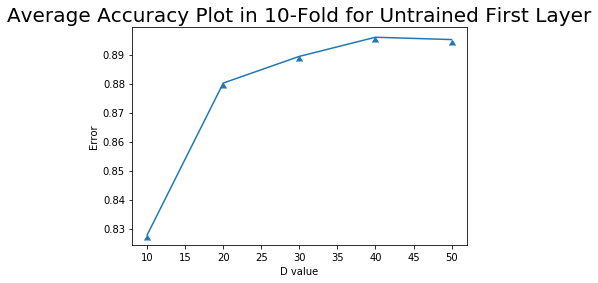

In [1564]:
import matplotlib.pyplot as plt
d=[10,20,30,40,50]
average_acc = accMean
x_axis = d
y_axis = average_acc

plt.plot(x_axis, y_axis, marker=6)

plt.title('Average Accuracy Plot in 10-Fold for Untrained First Layer', fontsize=20)
plt.xlabel('D value')
plt.ylabel('Error') #It should be Accuracy-> use plt.ylabel('Acc:') instead!


plt.show()

**Until here we did not train the first layer thus Rahimi’s technique was implemented.
As we can see our neural network can classify data with just using linear classification after appropriate kernel approximation. **

In [ ]:
##############TRAN THE FIRST LAYER ALSO################

In [1567]:
from sklearn.model_selection import KFold

kf=KFold(n_splits=10, random_state=None, shuffle=False)
counter=1

acc=0
accMean=[]
#Index of best parameters
g=0
mb=1
opt=0
dr=0
lr=3
for d in range(len(params['D'])):      
                            
    acc=0
                                
    for train_index, test_index in kf.split(X_train):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]
                                    
        SLFN = NeuralNet(D=params['D'][d],g=params['g'][g],learning_rate=params['learning_rate'][lr],
                                     epochs=20,train_flag=True,
                                        optimization=params['optimizer'][opt],decay_rate=params['decay_rate'][dr])
                        
            
        SLFN.fit(x_train, y_train,x_test,y_test,minibach_size=params['minibach_size'][mb])
        pred = SLFN.predict(x_test)
        predicted_class = np.argmax(pred, axis=1)
        acc += (np.mean(predicted_class == y_test))
        print('D: '+str(params['D'][d])+' g: '+str(params['g'][g])+' lr: '+str(params['learning_rate'][lr])+
                                         ' opt: '+str(params['optimizer'][opt])+' dr: '+str(params['decay_rate'][dr])+' mb: '+str(params['minibach_size'][mb])
                                          +' ACC: '+str((np.mean(predicted_class == y_test))))
                                           
    acc = acc/10 
    accMean.append(acc)
    print('Mean accuracy for D: '+str(params['D'][d])+' is :' +str(accMean[d]))

D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.888
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.908
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.9
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.894
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.892
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.86
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.88
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.898
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.894
D: 10 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.91
Mean accuracy for D: 10 is :0.8924
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.892
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.902
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.912
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.884
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.898
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb: 64 ACC: 0.864
D: 20 g: 1 lr: 0.1 opt: RMSprob dr: 0.9 mb

In [1568]:
accMean

[0.8924, 0.8934, 0.8943999999999999, 0.8958, 0.8949999999999999]

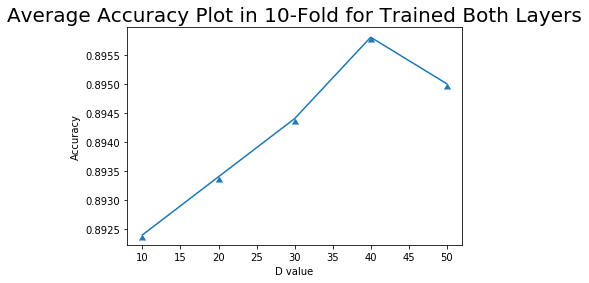

In [1569]:
import matplotlib.pyplot as plt
d=[10,20,30,40,50]
average_acc = accMean
x_axis = d
y_axis = average_acc

plt.plot(x_axis, y_axis, marker=6)

plt.title('Average Accuracy Plot in 10-Fold for Trained Both Layers', fontsize=20)
plt.xlabel('D value')
plt.ylabel('Accuracy')


plt.show()

**When we also train the first layer accuracy values are also increased as we can see on the figure above! **